In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from category_encoders import OneHotEncoder

In [2]:
# Data set of Dubai Real Estate from 01/01/2021 till 11/01/2023
df = pd.read_csv('transactions-2023-01-11.csv')

In [3]:
def impute_data(df):
    df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])
    # Replace NaN values with Propety Type
    df["Property Sub Type"] = df["Property Sub Type"].fillna("Land")
    # Replace Nan values where there is no closest Metro Station or Mall with "No metro around", "No mall around"
    df["Nearest Metro"] = df["Nearest Metro"].fillna("No metro around")
    df["Nearest Mall"] = df["Nearest Mall"].fillna("No mall around")
    df["Nearest Landmark"] = df["Nearest Landmark"].fillna("No landmark around")
    return df

In [4]:
def drop_excess_columns(data):
    # Drop high cardinality columns
    data = data.drop(columns=["Transaction Number", "Property ID", "Transaction Size (sq.m)", "Parking", "Project"])
    # Drop low-cardinality columns
    data = data.drop(columns=["Registration type", "Is Free Hold?", "Master Project"])
    # Drop leaky columns
    data = data.drop(columns=["Transaction sub type", "Property Type", "Room(s)", "No. of Buyer", "No. of Seller"])
    return data


In [5]:
df = impute_data(df)
df = drop_excess_columns(df)

In [6]:
def get_oil_price():
    # data from https://tradingeconomics.com/commodity/crude-oil
    r = requests.get('https://markets.tradingeconomics.com/chart?s=cl1:com&interval=1w&span=5y&securify=new&url=/commodity/crude-oil&AUTH=nCUl2XKce%2BoKz2Gux8jbnsBR9lI4I5ttOWajwJM4oCel63SvMd94HQyeKvWrZV4R&ohlc=0')
    oil_data = pd.DataFrame(r.json()['series'][0]['data']).rename(columns={"y": "price"})
    oil_data = oil_data[(oil_data['date'] > '2020-12-31') & (oil_data['date'] < '2022-01-01')]

    return oil_data
    

In [7]:
# oil_data = get_oil_price()
# oil_data.head()

In [8]:
def drop_period_after_war(data):
    war_date = '2022-02-24'
    return data[data['Transaction Date'] < war_date]

In [9]:
df = drop_period_after_war(df)

In [10]:
def split (target_col, df, test_size=0.2):
    target = target_col  # takes name of target column as string
    # subset target vector from explanatory matrix
    y = df[target]  
    X = df.drop(columns=[target, "Transaction Date"])

    #  Performes train - test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # print("X_train shape:", X_train.shape)
    # print("y_train shape:", y_train.shape)
    # print("X_test shape:", X_test.shape)
    # print("y_test shape:", y_test.shape)
    return y, X, X_train, X_test, y_train, y_test

In [11]:
def baseline ():
    y_mean = y_train.mean()
    y_pred_baseline = [y_mean] * len(y_train)

    print("Mean apt price:", round(y_mean, 2))

    print("Baseline MSE:", round(mean_squared_error(y_train, y_pred_baseline) / 1_000_000_000, 2), "millions")
    pass

In [12]:
def regression (explanatory_matrix, dependent_vector):
    model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        Ridge()
    ).fit(explanatory_matrix, dependent_vector)
    return model

In [19]:
y, X, X_train, X_test, y_train, y_test = split("Amount", df)

In [20]:
model = regression(X_train, y_train)

In [21]:
coef = model.named_steps["ridge"].coef_
intercept = model.named_steps["ridge"].intercept_

In [22]:
y_pred_training = model.predict(X_train)
residuals = y_train - y_pred_training
# print("Training MSE:", round(mean_squared_error(y_train, y_pred_training) / 1_000_000_000, 2), "millions")

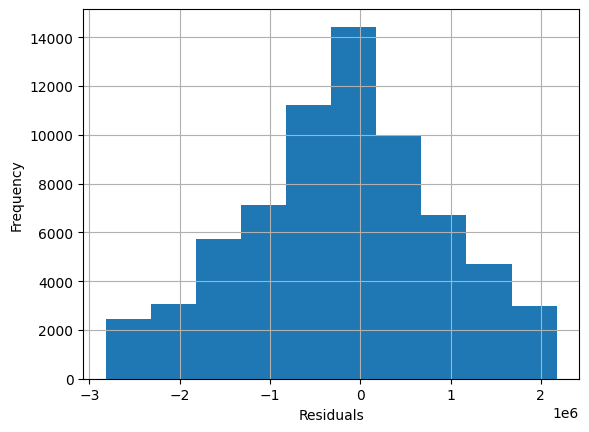

In [44]:
low, high = residuals.quantile([0.1, 0.90])
mask_area = residuals.between(low, high)
trimmed_resid = residuals[mask_area]
trimmed_resid.hist()
plt.xlabel("Residuals")
plt.ylabel("Frequency");

Gauss-Markov Assumption's
1. A1 => Expected value (disturbance) = 0
2. A2 => {e1 .... en} and {x1 .... xn} are independent. Disturbance terms and explanatory variables are independent of each other
3. A3 => Var{ei} = sigma^2 Variance of disturbances is constant
4. A4 => Cov(ei, ej) = 0, Covariance between disturbances = 0


Violation of A3 of Gauss-Markov assumption's => Disturbances aren't constant <br>
HETEROSKEDASTICITY TEST'S:<br>
1. White test
2. Goldfeld-Quandt test
3. Glejger test
4. Breush-Pagan test

In [72]:
transformed_set = OneHotEncoder(use_cat_names=True).fit(X_train).transform(X_train)
transformed_set = sm.add_constant(transformed_set)

In [69]:
#perform White's test
white_test = sm.stats.diagnostic.het_white(np.array(residuals), transformed_set)

#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of White's test
print(dict(zip(labels, np.around(white_test, 2))))

MemoryError: Unable to allocate 44.0 GiB for an array with shape (69006, 85551) and data type float64

In [73]:
transformed_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85551 entries, 28905 to 30269
Columns: 371 entries, const to Nearest Landmark_Jabel Ali
dtypes: float64(2), int64(369)
memory usage: 242.8 MB
